Component orientations (from dataless seed downloaded on June 29, 2019)
BHU: az 135.1 dip -29.4
BHV: az 15.0  dip -29.2
BHW: az 255.0 dip -29.7

### Load, rotate, and plot data

In [124]:
import os
from obspy import read
from obspy.signal.rotate import rotate_ne_rt, rotate2zne
import matplotlib.pyplot as plt

# === Parameters ===
# filedir = "H:\My Drive\Research\SharpSSPy"
filedir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/SharpSSPy"

evname = "S1094b"
dtype = "VEL"
pzfilter = True

datadir = os.path.join(filedir, "misc", evname)

# === Load the 3 components ===
st_z = read(os.path.join(datadir, f"{evname}_{dtype}_BHZ.SAC"))[0]
st_r = read(os.path.join(datadir, f"{evname}_{dtype}_BHR.SAC"))[0]
st_t = read(os.path.join(datadir, f"{evname}_{dtype}_BHT.SAC"))[0]

t = st_z.times()
start_time = st_z.stats.starttime

In [125]:
from obspy import UTCDateTime

fmin = 0.3
fmax = 0.9

P_arrival = UTCDateTime("2021-12-24T22:45:09.075499")
S_arrival = UTCDateTime("2021-12-24T22:50:51.836923")

t -= P_arrival - start_time

tr_z_filtered = st_z.copy().filter("bandpass", freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
tr_r_filtered = st_r.copy().filter("bandpass", freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
tr_t_filtered = st_t.copy().filter("bandpass", freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)

# --- Define overall time range to cut the trace ---
tmin, tmax = -20, 80  # seconds, adjust as needed

# --- Cut the trace ---
mask_full = (t >= tmin) & (t <= tmax)
t_cut = t[mask_full]
z_cut = tr_z_filtered[mask_full]

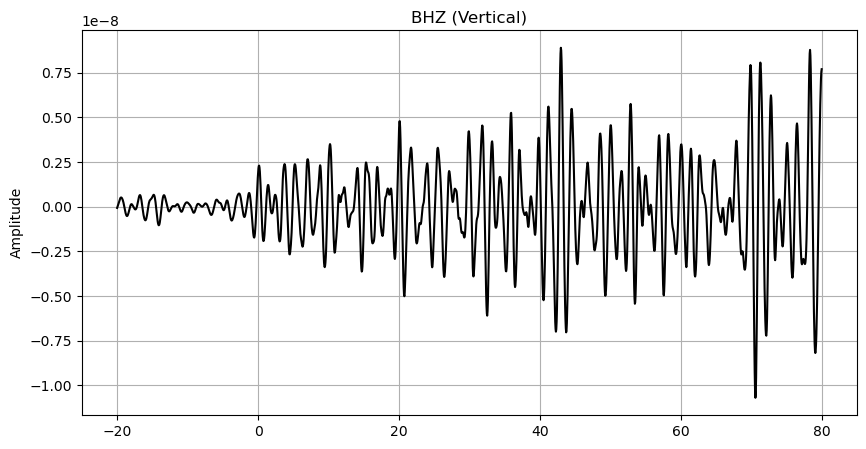

In [126]:
plt.figure(figsize=(10, 5))
plt.plot(t_cut, z_cut, color="black")
# plt.xlim(-15, 75)
plt.title("BHZ (Vertical)")
plt.ylabel("Amplitude")
plt.grid()

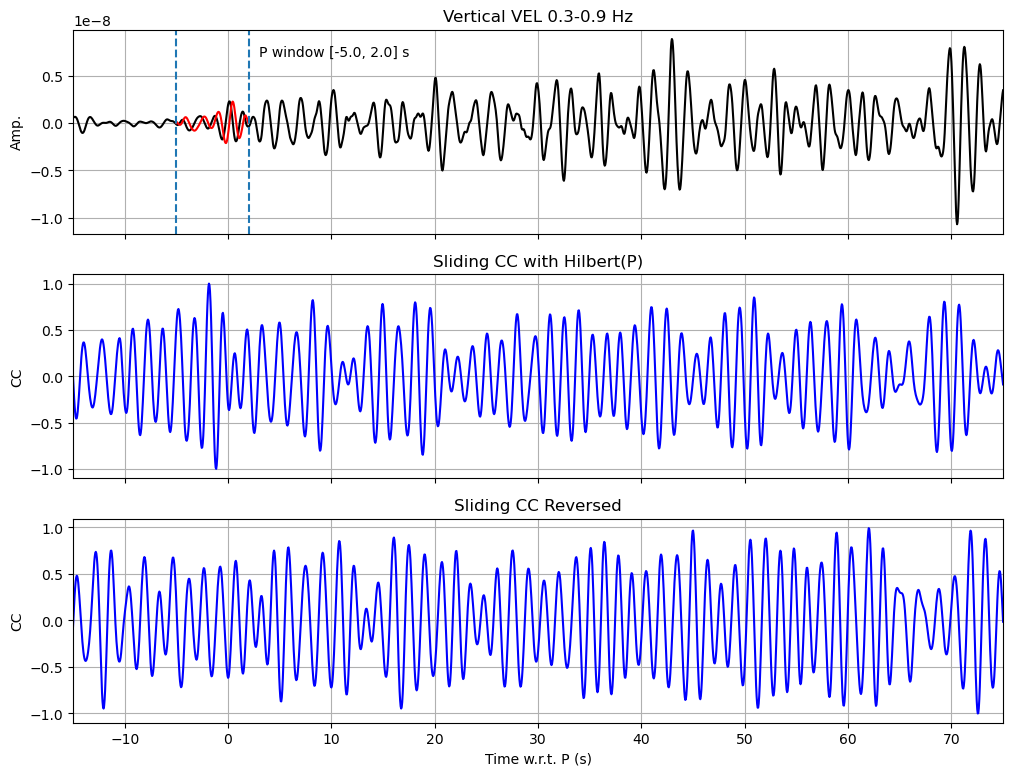

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# --- Parameters ---
window = [-5.0, 2.0]  # seconds around 0 for the Hilbert window
# corr_window = len(t_win)  # use same length as Hilbert trace

# --- Select window around 0 ---
mask = (t_cut >= window[0]) & (t_cut <= window[1])
P_win = z_cut[mask]

# --- Hilbert transform of the windowed trace ---
hilbert_P = np.imag(hilbert(P_win))

hilbert_P_for_plot = np.full_like(z_cut, np.nan)  # initialize with NaNs
hilbert_P_for_plot[mask] = hilbert_P             # fill in values where window is

# --- Running cross-correlation ---
# We'll slide hilbert_trace along the full trace and compute correlation at each point
n = len(z_cut)
m = len(hilbert_P)

# normalize both signals
hilbert_norm = (hilbert_P - np.mean(hilbert_P)) / np.std(hilbert_P)

cc = np.zeros(n)
cc_reverse = np.zeros(n)

for i in range(n - m + 1):
    segment = z_cut[i:i+m]
    seg_norm = (segment - np.mean(segment)) / np.std(segment)
    cc[i + m//2] = np.correlate(seg_norm, hilbert_norm, mode='valid').item()
    cc_reverse[i + m//2] = np.correlate(seg_norm, hilbert_norm[::-1], mode='valid').item()

# normalize
cc /= max(abs(cc))
cc_reverse /= max(abs(cc_reverse))

# pad edges with NaNs (optional, for plotting alignment)
cc[:m//2] = np.nan
cc[-m//2:] = np.nan
cc_reverse[:m//2] = np.nan
cc_reverse[-m//2:] = np.nan

# --- Plot cross-correlation ---
plt.figure(figsize=(12,9))

ax = plt.subplot(3,1,1)
plt.plot(t_cut, z_cut, color="black")
plt.plot(t_cut, hilbert_P_for_plot, color='red')
plt.text(window[1] + 1, max(z_cut) * 0.8, f"P window {window} s")
plt.axvline(window[0], linestyle='--')
plt.axvline(window[1], linestyle='--')
plt.xlim(-15, 75)
plt.title(f"Vertical VEL {fmin}-{fmax} Hz")
plt.ylabel("Amp.")
ax.set_xticklabels([])
plt.grid(True)

ax = plt.subplot(3,1,2)
plt.plot(t_cut, cc, color='blue', label='Running cross-correlation')
# plt.axhline(0.7, color='r', linestyle=':')
# plt.axhline(-0.7, color='r', linestyle=':')
plt.xlim(-15, 75)
plt.ylabel('CC')
plt.title('Sliding CC with Hilbert(P)')
ax.set_xticklabels([])
plt.grid(True)

ax = plt.subplot(3,1,3)
plt.plot(t_cut, cc_reverse, color='blue', label='Running cross-correlation')
# plt.axhline(0.7, color='r', linestyle=':')
# plt.axhline(-0.7, color='r', linestyle=':')
plt.xlim(-15, 75)
plt.xlabel('Time w.r.t. P (s)')
plt.ylabel('CC')
plt.title('Sliding CC Reversed')
plt.grid(True)
plt.show()


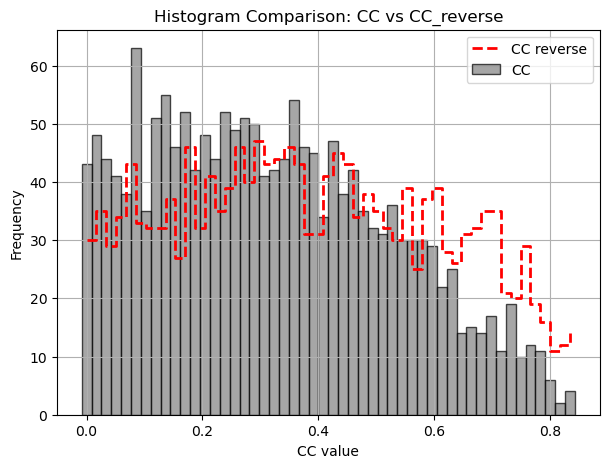

In [128]:
# === Plot Histogram of CC values ===
cc = np.abs(cc)
cc_reverse = np.abs(cc_reverse)
mask_hist = (t_cut < window[0]) | (t_cut > window[1])
cc_hist = cc[mask_hist]
cc_reverse_hist = cc_reverse[mask_hist]

# Remove NaNs
cc_hist = cc_hist[~np.isnan(cc_hist)]
cc_reverse = cc_reverse_hist[~np.isnan(cc_reverse_hist)]

# Example: cc_hist and cc_reverse_hist are your arrays (after masking)
bins = 50  # number of bins

# Compute histogram counts and bin edges
counts1, bin_edges = np.histogram(cc_hist, bins=bins)
counts2, _ = np.histogram(cc_reverse_hist, bins=bin_edges)  # use same bins

# Plot
plt.figure(figsize=(7,5))

# Filled histogram for cc_hist
plt.bar(bin_edges[:-1], counts1, width=np.diff(bin_edges), color='gray', edgecolor='black', alpha=0.7, label='CC')

# Overlay dashed step plot for cc_reverse
plt.step(bin_edges[:-1], counts2, where='post', linestyle='--', color='red', linewidth=2, label='CC reverse')

plt.xlabel("CC value")
plt.ylabel("Frequency")
plt.title("Histogram Comparison: CC vs CC_reverse")
plt.legend()
plt.grid(True)
plt.show()